In [14]:
import pandas as pd

df = pd.read_csv('Merge.csv')
# print(df.info())
# print(df.describe())
df['datetime'] = pd.to_datetime(df['datetime'])

In [15]:
df_rfm = df.groupby('user_id').agg({
    'datetime':
    lambda x: (pd.to_datetime('2020-12-31') - x.max()).days,
    'user_id':
    lambda x: len(x),
    'quantity':
    lambda x: x.sum()
})
print(df_rfm.head())

         datetime  user_id   quantity
user_id                              
0             391       10   0.153989
1            1385        7  38.541973
2               9        1  14.504651
3             915       15  36.900266
4             965        5  24.731777


In [16]:
df_rfm.rename(columns={
    'datetime': 'R',
    'user_id': 'F',
    'quantity': 'M'
},
              inplace=True)
print(df_rfm.head())

            R   F          M
user_id                     
0         391  10   0.153989
1        1385   7  38.541973
2           9   1  14.504651
3         915  15  36.900266
4         965   5  24.731777


In [17]:
df_rfm.describe()

,R,F,M
count,486.000000,486.000000,486.000000
mean,387.277778,298.755144,969.494308
std,482.446342,800.146226,2821.494019
min,0.000000,1.000000,0.028468
25%,9.000000,18.000000,51.150363
50%,93.000000,61.500000,229.517501
75%,820.000000,249.750000,761.991371
max,1458.000000,9138.000000,32768.883857


In [19]:
def r_score(x):
    if x<=10:
        return 4
    elif x<=94:
        return 3
    elif x<=821:
        return 2
    else:
        return 1

def f_score(x):
    if x<=19:
        return 4
    elif x<=62:
        return 3
    elif x<=250:
        return 2
    else:
        return 1   
    
def m_score(x):
    if x<=52:
        return 4
    elif x<=230:
        return 3
    elif x<=762:
        return 2
    else:
        return 1

df_rfm['r_score'] = df_rfm['R'].apply(r_score)
df_rfm['f_score'] = df_rfm['F'].apply(f_score)
df_rfm['m_score'] = df_rfm['M'].apply(m_score)
print(df_rfm.head())

            R   F          M  r_score  f_score  m_score
user_id                                                
0         391  10   0.153989        2        4        4
1        1385   7  38.541973        1        4        4
2           9   1  14.504651        4        4        4
3         915  15  36.900266        1        4        4
4         965   5  24.731777        1        4        4


In [20]:
df_rfm['R高低'] = df_rfm['r_score'].apply(lambda x: '高' if x > df_rfm['r_score'].mean() else '低')
df_rfm['F高低'] = df_rfm['f_score'].apply(lambda x: '高' if x > df_rfm['f_score'].mean() else '低')
df_rfm['M高低'] = df_rfm['m_score'].apply(lambda x: '高' if x > df_rfm['m_score'].mean() else '低')
print(df_rfm.head())

            R   F          M  r_score  f_score  m_score R高低 F高低 M高低
user_id                                                            
0         391  10   0.153989        2        4        4   低   高   高
1        1385   7  38.541973        1        4        4   低   高   高
2           9   1  14.504651        4        4        4   高   高   高
3         915  15  36.900266        1        4        4   低   高   高
4         965   5  24.731777        1        4        4   低   高   高


In [21]:
df_rfm['RFM'] = df_rfm['R高低'] + df_rfm['F高低'] + df_rfm['M高低']
# 将 R 高低、F 高低 和 M 高低 加起来, 也就是拼接成 高低高 这种字符串
# 这样直接分析 RFM 这列的字符串排列就能知道该用户是哪种类型的:
def rfm_type(x):
  if x == '高高高':
    return '重要价值用户'
  elif x == '低高高':
    return '重要唤回用户'
  elif x == '高低高':
    return '重要深耕用户'
  elif x == '低低高':
    return '重要挽留用户'
  elif x == '高高低':
    return '潜力用户'
  elif x == '高低低':
    return '新用户'
  elif x == '低高低':
    return '一般维持用户'
  elif x == '低低低':
    return '流失用户'

df_rfm['用户类型'] = df_rfm['RFM'].apply(rfm_type)
print(df_rfm.head())

            R   F          M  r_score  f_score  m_score R高低 F高低 M高低  RFM  \
user_id                                                                    
0         391  10   0.153989        2        4        4   低   高   高  低高高   
1        1385   7  38.541973        1        4        4   低   高   高  低高高   
2           9   1  14.504651        4        4        4   高   高   高  高高高   
3         915  15  36.900266        1        4        4   低   高   高  低高高   
4         965   5  24.731777        1        4        4   低   高   高  低高高   

           用户类型  
user_id          
0        重要唤回用户  
1        重要唤回用户  
2        重要价值用户  
3        重要唤回用户  
4        重要唤回用户  


In [22]:
# (1) 首先看看每种类型的用户分别有多少人
df_rfm['用户类型'].value_counts()

新用户       184
重要唤回用户    174
重要价值用户     48
流失用户       36
一般维持用户     14
重要深耕用户     13
潜力用户        9
重要挽留用户      8
Name: 用户类型, dtype: int64

In [23]:
df_count = df_rfm['用户类型'].value_counts().reset_index()
print(df_count)

    index  用户类型
0     新用户   184
1  重要唤回用户   174
2  重要价值用户    48
3    流失用户    36
4  一般维持用户    14
5  重要深耕用户    13
6    潜力用户     9
7  重要挽留用户     8


In [24]:
df_count.rename(columns={'index': '用户类型', '用户类型': '人数'}, inplace=True)
print(df_count)

     用户类型   人数
0     新用户  184
1  重要唤回用户  174
2  重要价值用户   48
3    流失用户   36
4  一般维持用户   14
5  重要深耕用户   13
6    潜力用户    9
7  重要挽留用户    8


In [25]:
# 给表格再加一列, 计算出每种类型的用户的占比分别是多少
df_count['占比'] = df_count['人数'] / df_count['人数'].sum()  # 人数 /总人数
print(df_count)

     用户类型   人数        占比
0     新用户  184  0.378601
1  重要唤回用户  174  0.358025
2  重要价值用户   48  0.098765
3    流失用户   36  0.074074
4  一般维持用户   14  0.028807
5  重要深耕用户   13  0.026749
6    潜力用户    9  0.018519
7  重要挽留用户    8  0.016461


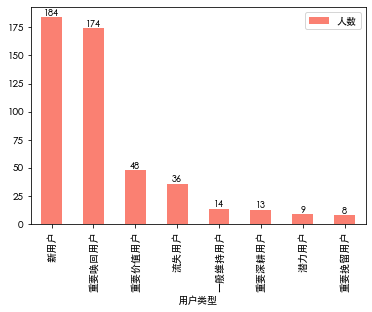

In [76]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Heiti TC'

pd.set_option('display.unicode.ambiguous_as_wide', True)
pd.set_option('display.unicode.east_asian_width', True)

df_count.plot(kind='bar', x='用户类型', y='人数', color='salmon')

import numpy as np
x = np.arange(8)

for a,b in zip(x,df_count['人数']):
    plt.text(a, b+0.001, '%.0f' % b, ha='center', va= 'bottom',fontsize=9)


plt.show()  # 需要提前 import matplotlib.pyplot as plt

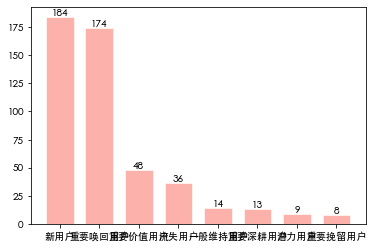

In [68]:
width_val = 0.7
bar1 = plt.bar(df_count['用户类型'],df_count['人数'], alpha=0.6, width = width_val, facecolor = 'salmon')

# 添加数据标签 就是矩形上面的数值
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2, height, height, ha='center', va='bottom')
        rect.set_edgecolor('white')
 
add_labels(bar1)

plt.show()

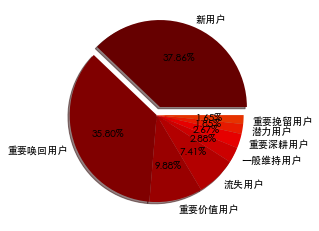

In [43]:
plt.pie(x=df_count['人数'],
        labels=df_count['用户类型'],
        explode=[0.1, 0, 0, 0, 0, 0, 0, 0],
        shadow=True,
        autopct="%0.2f%%",
        colors=[(0.4, 0, 0),(0.5, 0, 0),(0.6, 0, 0),(0.7, 0, 0),(0.8, 0, 0),(0.9, 0, 0),(0.9, 0.1, 0),(0.9, 0.2, 0)]
       )
plt.show()